In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
plt.rcParams["axes.labelsize"] = 14
import scipy
import scipy.io as sio
import matplotlib.pyplot as plt
import sklearn.decomposition
from pyriemann.utils.mean import mean_covariance
import pickle
from sklearn.metrics import confusion_matrix

In [2]:
def geodesic(Q1, Q2):
    Q1_inv_sqrt = q1invm(Q1)
    Q = Q1_inv_sqrt @ Q2 @ Q1_inv_sqrt
    U, S, V = scipy.linalg.svd(Q)
    dG = np.sqrt(np.sum(np.log(S)**2))
    return dG

def pca_recon(FC, pctComp=None):
    '''
    Reconstructs FC based on number of principle components
    '''
    if pctComp is None:
        return FC
    nRegions = FC.shape[1]
    FC = np.reshape(FC, (FC.shape[0], -1))
    nComp = int(FC.shape[0] * pctComp)
    mu = np.mean(FC, axis=0)
    pca_rest = sklearn.decomposition.PCA()
    pca_rest.fit(FC)
    cumsum = np.cumsum(pca_rest.explained_variance_ratio_)
    SCORES = pca_rest.transform(FC)[:, :nComp]
    COEFFS = pca_rest.components_[:nComp, :]
    FC_recon = np.dot(SCORES, COEFFS)
    del SCORES, COEFFS
    FC_recon += mu
    FC_recon = np.reshape(FC_recon, (FC.shape[0], nRegions, nRegions))
    return FC_recon, cumsum

def tangential(all_FC, ref):
    # Regularization for riemann
    if ref in ['riemann', 'kullback_sym', 'logeuclid']:
        print("Adding regularization!")
        eye_mat = np.eye(all_FC.shape[1])
        scaling_mat = np.repeat(eye_mat[None, ...], all_FC.shape[0], axis=0)
        all_FC += scaling_mat
    Cg = mean_covariance(all_FC, metric=ref)
    Q1_inv_sqrt = q1invm(Cg)
    Q = Q1_inv_sqrt @ all_FC @ Q1_inv_sqrt
    tangent_FC = np.array([qlog(a) for a in Q])
    return tangent_FC

def q1invm(q1, eig_thresh=0):
    U, S, V = scipy.linalg.svd(q1)
    s = np.diag(S)
    s[s < eig_thresh] = eig_thresh
    S = np.diag(s ** (-1 / 2))
    Q1_inv_sqrt = U * S * np.transpose(V)
    Q1_inv_sqrt = (Q1_inv_sqrt + np.transpose(Q1_inv_sqrt)) / 2
    return Q1_inv_sqrt


def qlog(q):
    U, S, V = scipy.linalg.svd(q)
    s = np.diag(S)
    S = np.diag(np.log(s))
    Q = U * S * np.transpose(V)
    return Q


def get_glasser():
    '''
    Navigates through file tree and extracts FCs with optional reconstruction
    '''
    # Yeo ordering
    fname = '../data/100_unrelated.csv'
    yeo = True
    if yeo:
        yeo_order = list(sio.loadmat("../data/yeo_RS7_N374.mat",
                                     squeeze_me=True,
                                     struct_as_record=False)['yeoOrder'] - 1)
    # Load subject ID and task names
    subjectids = np.loadtxt(fname, dtype=np.int)
    nSubj = len(subjectids)
    tasks = ['rfMRI_REST1_LR', 'rfMRI_REST1_RL', 'rfMRI_REST2_LR',
             'rfMRI_REST2_RL', 'tfMRI_EMOTION_LR', 'tfMRI_EMOTION_RL',
             'tfMRI_GAMBLING_LR', 'tfMRI_GAMBLING_RL', 'tfMRI_LANGUAGE_LR',
             'tfMRI_LANGUAGE_RL', 'tfMRI_MOTOR_LR', 'tfMRI_MOTOR_RL',
             'tfMRI_RELATIONAL_LR', 'tfMRI_RELATIONAL_RL', 'tfMRI_SOCIAL_LR',
             'tfMRI_SOCIAL_RL', 'tfMRI_WM_LR', 'tfMRI_WM_RL']
    M = {}
    # Walk through file tree and extract FCs
    for task in tasks:
        masterFC_dir = '../data/results_SIFT2'
        restingstatename = 'fMRI/' + task + '/FC/FC_glasser_subc_GS_bp_z.mat'
        task_matrices = []
        for subject in subjectids:
            filename = masterFC_dir + '/' + \
                str(subject) + '/' + restingstatename
            mat = sio.loadmat(filename, squeeze_me=True,
                              struct_as_record=False)
            A_orig = mat['FC']
            if yeo:
                A_orig = A_orig[np.ix_(yeo_order, yeo_order)]
            np.fill_diagonal(A_orig, 1)
            task_matrices.append(A_orig)
        M[task] = np.array(task_matrices)
    test = np.concatenate((M['rfMRI_REST1_LR'], M['tfMRI_EMOTION_LR'],
                           M['tfMRI_GAMBLING_LR'], M['tfMRI_LANGUAGE_LR'],
                           M['tfMRI_MOTOR_LR'], M['tfMRI_RELATIONAL_LR'],
                           M['tfMRI_SOCIAL_LR'], M['tfMRI_WM_LR']))
    retest = np.concatenate((M['rfMRI_REST1_RL'], M['tfMRI_EMOTION_RL'],
                             M['tfMRI_GAMBLING_RL'], M['tfMRI_LANGUAGE_RL'],
                             M['tfMRI_MOTOR_RL'], M['tfMRI_RELATIONAL_RL'],
                             M['tfMRI_SOCIAL_RL'], M['tfMRI_WM_RL']))
    del M
    all_FC = np.concatenate((test, retest))
    del test, retest
    return all_FC, nSubj

def get_schaefer(parc, ref='none', twins=False):
    if ref.lower() == 'none':
        with open(f'../data/schaefer/schaefer{parc}.pickle', 'rb') as f:
            all_FC = pickle.load(f)
    else:
        if twins is True:
            with open(f'../data/tangent_fcs/twins/rest/100_MZ_{ref}.pickle', 'rb') as f:
                all_FC = pickle.load(f)
        else:
            with open(f'../data/tangent_fcs/schaefer{parc}_{ref}.pickle', 'rb') as f:
                all_FC = pickle.load(f)
    nSubj = int(all_FC.shape[0]/16)
    return all_FC, nSubj

## HCP 100 Subjects CNN with 3 Pipelines

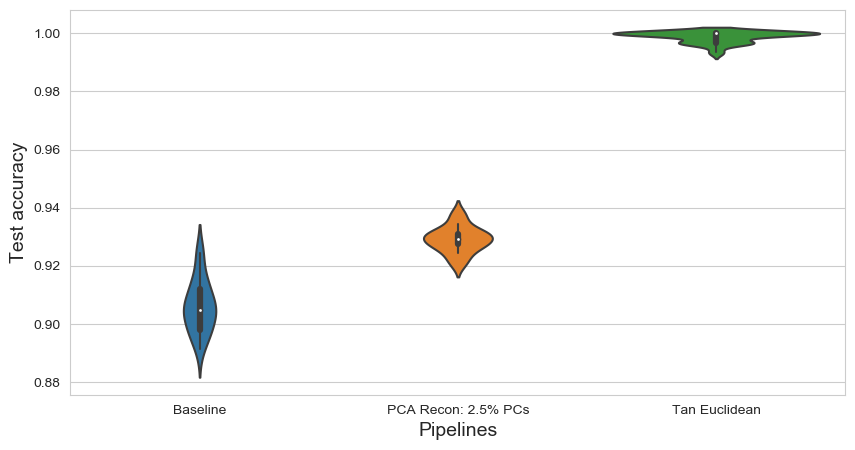

In [51]:
sns.set_style("whitegrid")
baseline = pd.read_csv('HCP100_base_E200_LR0.001_R1_S0_Y1_20.csv')
tan_euclidean = pd.read_csv('HCP100_Taneuclid_E200_LR0.001_R1_S0_Y1_20.csv')
pca_recon = pd.read_csv('HCP100_recon_0.025_E200_LR0.001_R0_S0_Y1.csv')
df = pd.concat([baseline['Accuracy'], pca_recon['Accuracy'],
                tan_euclidean['Accuracy']], axis=1,
               keys=['Baseline', 'PCA Recon: 2.5% PCs', 'Tan Euclidean'])
df = df.melt(var_name='Pipelines', value_name='Test accuracy')
ax = sns.violinplot(x="Pipelines", y="Test accuracy", data=df)
fig = ax.get_figure()
fig.set_size_inches(10,5)
plt.savefig('DL_pipelines.eps', bbox_inches='tight', transparent=True)
plt.show()

## CNN with Tangent Space Schaefer

0.0027796137380313164


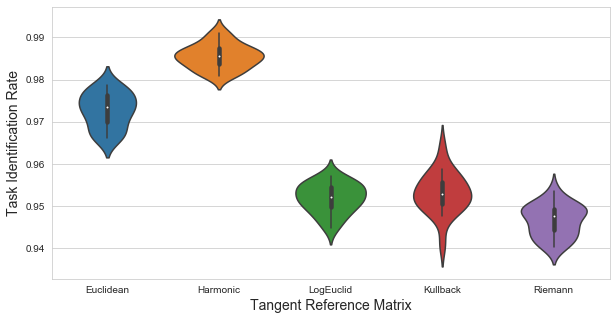

In [110]:
sns.set_style("whitegrid")
euclid = pd.read_csv('tasks/CNN_schaefer100_euclid.csv')
harmonic = pd.read_csv('tasks/CNN_schaefer100_harmonic.csv')
kullback_sym = pd.read_csv('tasks/CNN_schaefer100_kullback_sym.csv')
logeuclid = pd.read_csv('tasks/CNN_schaefer100_logeuclid.csv')
riemann = pd.read_csv('tasks/CNN_schaefer100_riemann.csv')
print(np.std(harmonic['Accuracy']))
df = pd.concat([euclid['Accuracy'], harmonic['Accuracy'],
                logeuclid['Accuracy'], kullback_sym['Accuracy'], riemann['Accuracy']], axis=1,
               keys=['Euclidean', 'Harmonic', 'LogEuclid', 'Kullback', 'Riemann'])
df = df.melt(var_name='Tangent Reference Matrix', value_name='Task Identification Rate')
ax = sns.violinplot(x="Tangent Reference Matrix", y="Task Identification Rate", data=df)
fig = ax.get_figure()
fig.set_size_inches(10,5)
plt.savefig('tasks/CNN_tangent.eps', bbox_inches='tight', transparent=True)
plt.show()

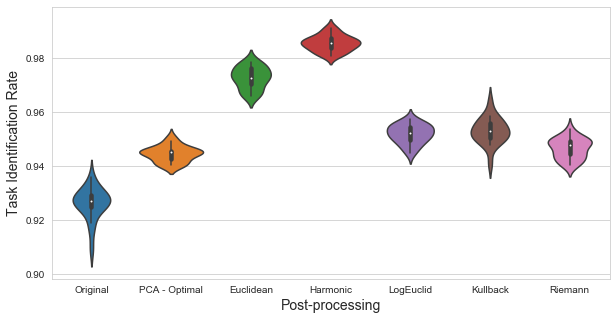

In [3]:
sns.set_style("whitegrid")
euclid = pd.read_csv('tasks/CNN_schaefer100_euclid.csv')
harmonic = pd.read_csv('tasks/CNN_schaefer100_harmonic.csv')
kullback_sym = pd.read_csv('tasks/CNN_schaefer100_kullback_sym.csv')
logeuclid = pd.read_csv('tasks/CNN_schaefer100_logeuclid.csv')
riemann = pd.read_csv('tasks/CNN_schaefer100_riemann.csv')
orig = pd.read_csv('tasks/CNN_schaefer100_none.csv')
pca = pd.read_csv('tasks/CNN_schaefer100_pca.csv')
df = pd.concat([orig['Accuracy'], pca['Accuracy'], euclid['Accuracy'], harmonic['Accuracy'],
                logeuclid['Accuracy'], kullback_sym['Accuracy'], riemann['Accuracy']], axis=1,
               keys=['Original', 'PCA - Optimal', 'Euclidean', 'Harmonic', 'LogEuclid', 'Kullback', 'Riemann'])
df = df.melt(var_name='Post-processing', value_name='Task Identification Rate')
ax = sns.violinplot(x="Post-processing", y="Task Identification Rate", data=df)
fig = ax.get_figure()
fig.set_size_inches(10,5)
plt.savefig('tasks/CNN_all.eps', bbox_inches='tight', transparent=True)
plt.show()

In [131]:
import csv
csv_file = 'tasks/pp_stats.csv'
csv_columns = ['PP', 'Mean', 'Std']
dict_data = [{'PP': 'Original', 'Mean':round(np.mean(orig['Accuracy']),3), 'Std':round(np.std(orig['Accuracy']),3)},
             {'PP': 'PCA', 'Mean':round(np.mean(pca['Accuracy']),3), 'Std':round(np.std(pca['Accuracy']),3)},
             {'PP': 'Euclidean', 'Mean':round(np.mean(euclid['Accuracy']),3), 'Std':round(np.std(euclid['Accuracy']),3)},
             {'PP': 'Harmonic', 'Mean':round(np.mean(harmonic['Accuracy']),3), 'Std':round(np.std(harmonic['Accuracy']),3)},
             {'PP': 'LogEuclid', 'Mean':round(np.mean(logeuclid['Accuracy']),3), 'Std':round(np.std(logeuclid['Accuracy']),3)},
             {'PP': 'Kullback', 'Mean':round(np.mean(kullback_sym['Accuracy']),3), 'Std':round(np.std(kullback_sym['Accuracy']),3)},
             {'PP': 'Riemann', 'Mean':round(np.mean(riemann['Accuracy']),3), 'Std':round(np.std(riemann['Accuracy']),3)}]

with open(csv_file, 'w') as csvfile:
    writer = csv.DictWriter(csvfile, fieldnames=csv_columns)
    writer.writeheader()
    for data in dict_data:
        writer.writerow(data)

## Task Classification on Closest FC without DL

In [4]:
distances = pd.read_csv('tasks/distances_tangent.csv', names=["Type", "Task Identification Rate"])
new = distances["Type"].str.rsplit("_", n = 1, expand = True) 
distances['Post-processing'] = new[0]
distances['Distance'] = new[1]
distances['Post-processing'][distances['Post-processing']=='none'] = 'original'
distances.drop(columns =["Type"], inplace = True) 
distances.head()


/Users/michael/anaconda3/envs/fmri/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


,Task Identification Rate,Post-processing,Distance
0,0.778676,original,correlation
1,0.780882,original,cosine
2,0.626471,original,euclidean
3,0.891176,pca,correlation
4,0.888235,pca,cosine


<Figure size 432x288 with 0 Axes>

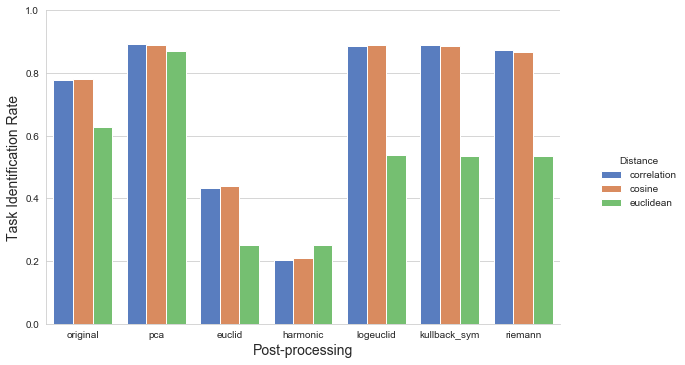

In [5]:
sns.set_style("whitegrid")
plt.tight_layout()
ref_plot = sns.catplot(x="Post-processing", y="Task Identification Rate", hue="Distance", data=distances,
                height=6, kind="bar", palette="muted", legend_out=True).set(ylim=(0, 1))
ref_plot.fig.set_size_inches(10,5)
plt.savefig('tasks/distance_task.eps', bbox_inches='tight', transparent=True)
plt.show()

/Users/michael/anaconda3/envs/fmri/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


<Figure size 432x288 with 0 Axes>

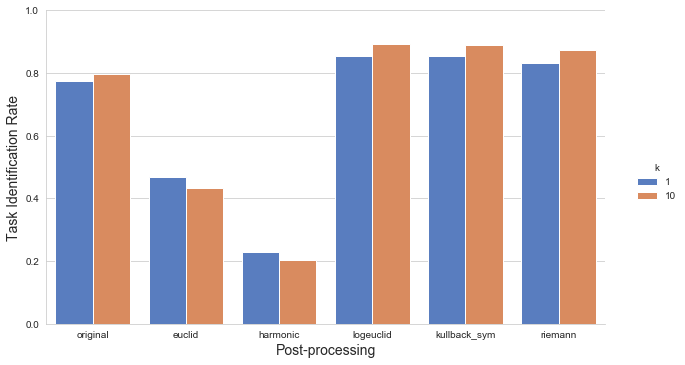

In [5]:
distances = pd.read_csv('tasks/distances_tangent_new.csv', names=["Type", "Task Identification Rate"])
new = distances["Type"].str.rsplit("_", n = 1, expand = True) 
distances['Post-processing'] = new[0]
distances['k'] = new[1]
distances['Post-processing'][distances['Post-processing']=='none'] = 'original'
distances.drop(columns =["Type"], inplace = True) 
distances.head()


sns.set_style("whitegrid")
plt.tight_layout()
ref_plot = sns.catplot(x="Post-processing", y="Task Identification Rate", hue="k", data=distances,
                height=6, kind="bar", palette="muted", legend_out=True).set(ylim=(0, 1))
ref_plot.fig.set_size_inches(10,5)
plt.savefig('tasks/distance_task_new.eps', bbox_inches='tight', transparent=True)
plt.show()

<Figure size 432x288 with 0 Axes>

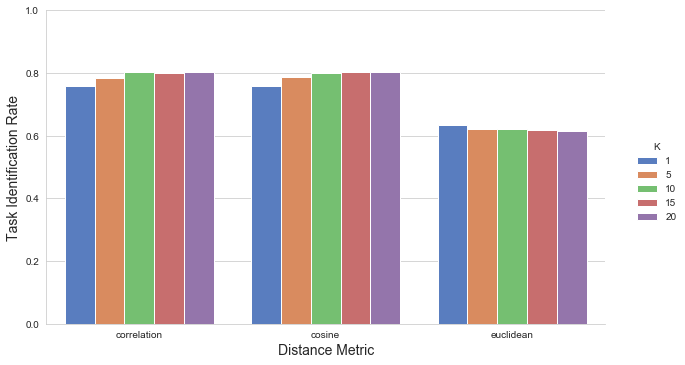

In [43]:
distances = pd.read_csv('tasks/distances_k.csv', names=["Type", "Task Identification Rate"])
new = distances["Type"].str.rsplit("_", n = 1, expand = True) 
distances['K'] = new[0]
distances['K'] = distances['K'].astype(int)
distances['Distance Metric'] = new[1]
distances.drop(columns =["Type"], inplace = True) 
distances.head()
sns.set_style("whitegrid")
plt.tight_layout()
ref_plot = sns.catplot(x="Distance Metric", y="Task Identification Rate", hue="K", data=distances,
                height=6, kind="bar", palette="muted", legend_out=True).set(ylim=(0, 1))
ref_plot.fig.set_size_inches(10,5)
plt.savefig('tasks/distance_k.eps', bbox_inches='tight', transparent=True)
plt.show()

## Schaefer Parcellations

In [ ]:
schaefer = pd.read_csv('schaefer_distances.csv', names=["Type", "Accuracy"])
new = schaefer["Type"].str.rsplit("_", n = 1, expand = True) 
schaefer['Parcellation'] = new[0]
schaefer['Tangent Reference'] = new[1]
schaefer.drop(columns =["Type"], inplace = True) 
schaefer.head()

In [ ]:
ref_plot = sns.catplot(x="Tangent Reference", y="Accuracy", hue="Parcellation", data=schaefer,
                height=6, kind="bar", palette="muted").set(ylim=(0, 1))
ref_plot.fig.suptitle('Schaefer Parcellation Task Classifier Accuracy with k=30 Closest FCs', y=1.02, fontsize='xx-large')
ref_plot.fig.set_size_inches(10,5)
plt.savefig('knn_task.eps', bbox_inches='tight', transparent=True)
plt.show()

In [20]:
def utri2mat(utri):
    n = int(-1 + np.sqrt(1 + 8 * len(utri))) // 2
    iu1 = np.tril_indices(n+1,-1)
    ret = np.empty((n+1, n+1))
    ret[iu1] = utri
    ret.T[iu1] = utri
    np.fill_diagonal()
    return ret

In [ ]:
import numpy as np
iu1 = np.triu_indices(5,1)
ret = np.zeros((5,5))
ret[iu1] = np.arange(1,11)
ret = np.zeros((5,5))
iu1 = np.tril_indices(5,-1)
iu2 = (iu1[0][::-1], iu1[1][::-1])
ret[iu1] = np.arange(1,11)
print(ret.transpose())

In [2]:
import pickle
with open('../data/schaefer100.pickle', 'rb') as f:
    all_parc = pickle.load(f)

## Visualize Connectomes

Performing PCA Recon
Performing tangent space projection


/Users/michael/anaconda3/envs/fmri/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: divide by zero encountered in power
/Users/michael/anaconda3/envs/fmri/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in log


(6784, 114, 114)


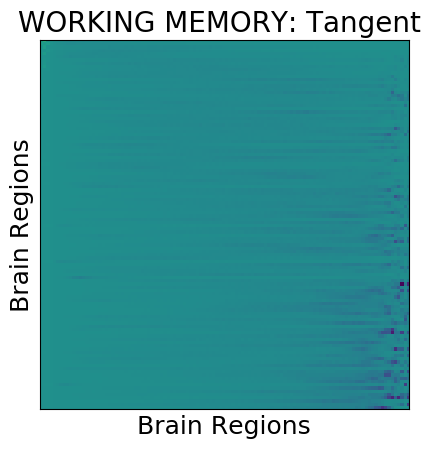

In [28]:
tasks = ['REST', 'EMOTION', 'GAMBLING', 'LANGUAGE', 'MOTOR', 'RELATIONAL', 'SOCIAL', 'WORKING MEMORY']
indices = np.arange(0,3816,424)
task_dict = {A: B for A, B in zip(tasks, indices)}
for proc in ['Raw', 'PCA', 'Tangent']:
    all_parc, nSubj = get_schaefer(100)
    if proc == 'PCA':
        print('Performing PCA Recon')
        all_parc, cumsum = pca_recon(all_parc, 0.01)
    elif proc == 'Tangent':
        print('Performing tangent space projection')
        all_parc = tangential(all_parc, 'euclid')
        print(all_parc.shape)
    for idx, task in enumerate(tasks):
        task_mean = np.mean(all_parc[indices[idx]:indices[idx+1]], 0)
        plt.style.use('default')
        plt.imshow(task_mean,origin='lower')
        plt.xticks([], [])
        plt.yticks([],[])
        plt.title(f'{task}: {proc} ', fontdict = {'fontsize' : 20})
        plt.ylabel('Brain Regions',fontdict = {'fontsize' : 18})
        plt.xlabel('Brain Regions',fontdict = {'fontsize' : 18})
        plt.clim(-1, 1)
        plt.savefig(f'Schaefer_avg_{proc}_{task}.eps', bbox_inches='tight', transparent=True)

In [6]:
tasks = ['REST', 'EMOTION', 'GAMBLING', 'LANGUAGE', 'MOTOR', 'RELATIONAL', 'SOCIAL', 'WORKING MEMORY']
indices = np.arange(0,2978,424)
task_dict = {A: B for A, B in zip(tasks, indices)}

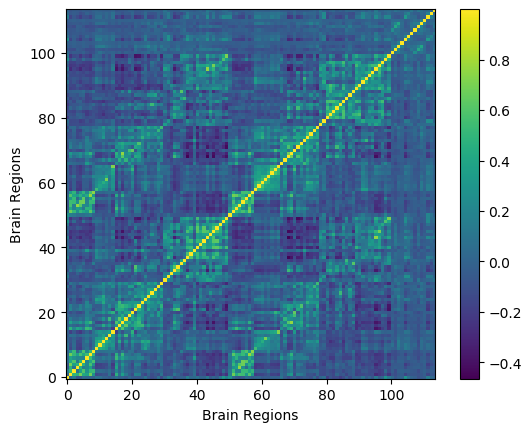

In [35]:
groupFC = np.mean(all_parc, 0)
plt.imshow(groupFC,origin='lower')
plt.colorbar()
plt.ylabel('Brain Regions')
plt.xlabel('Brain Regions')
plt.savefig('group_FC.eps', bbox_inches='tight', transparent=True)
plt.show()

# Tangent Space Connectomes

### Reference Matrices

Importing all correlation matrices... All FCs successfully loaded!

euclid


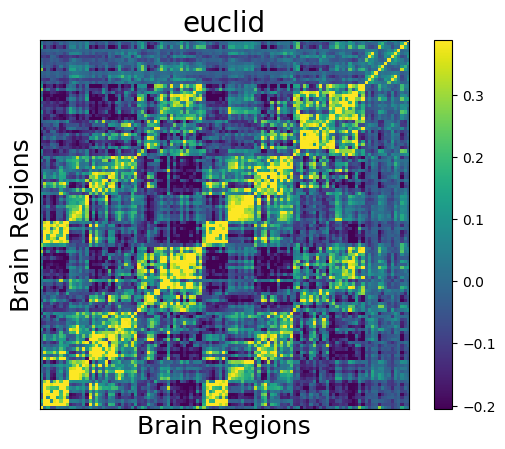

Importing all correlation matrices... All FCs successfully loaded!

kullback_sym
Adding regularization!


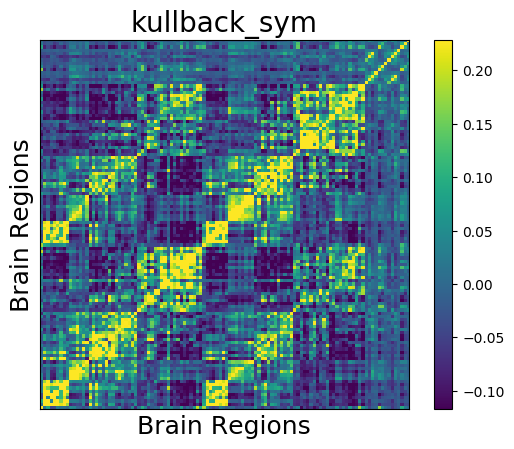

Importing all correlation matrices... All FCs successfully loaded!

harmonic


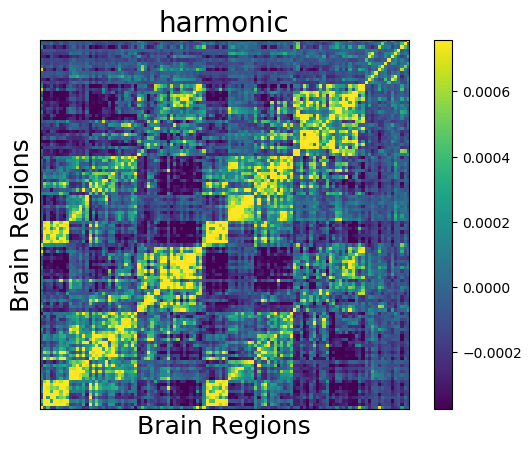

Importing all correlation matrices... All FCs successfully loaded!

logeuclid
Adding regularization!


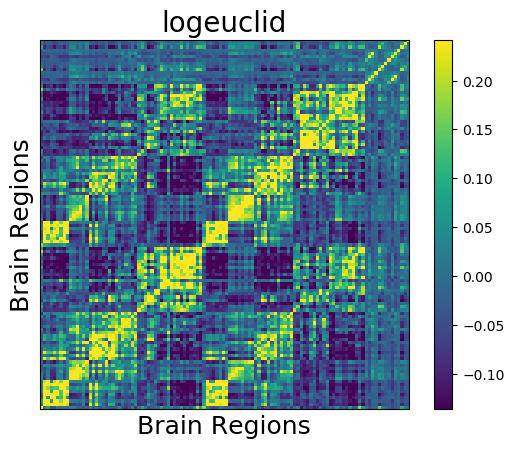

Importing all correlation matrices... All FCs successfully loaded!

riemann
Adding regularization!


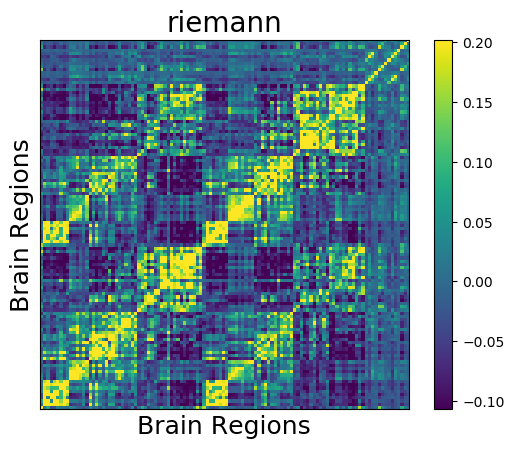

In [57]:
import matplotlib.pyplot as plt
import seaborn as sns
for ref in ['euclid', 'kullback_sym', 'harmonic', 'logeuclid', 'riemann']:
    print("Importing all correlation matrices...", end=" ")
    all_FC, nSubj = get_schaefer(100)
    print("All FCs successfully loaded!\n")
    print(ref)
    if ref in ['riemann', 'kullback_sym', 'logeuclid']:
        print("Adding regularization!")
        eye_mat = np.eye(all_FC.shape[1])
        scaling_mat = np.repeat(eye_mat[None, ...], all_FC.shape[0], axis=0)
        all_FC += scaling_mat
    Cg = mean_covariance(all_FC, metric=ref)
    plt.style.use('default')
    plt.imshow(Cg,origin='lower')
    plt.ylabel('Brain Regions')
    plt.xlabel('Brain Regions')
    plt.colorbar()
    plt.clim(np.percentile(Cg, 5), np.percentile(Cg, 95))
    plt.xticks([], [])
    plt.yticks([],[])
    plt.title(f'{ref}', fontdict = {'fontsize' : 20})
    plt.ylabel('Brain Regions',fontdict = {'fontsize' : 18})
    plt.xlabel('Brain Regions',fontdict = {'fontsize' : 18})
    plt.savefig(f'../results/reference_{ref}.eps', bbox_inches='tight')
    plt.show()

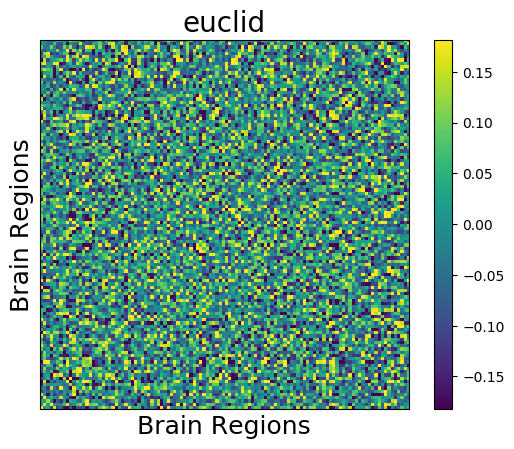

FileNotFoundError: [Errno 2] No such file or directory: '../data/tangent_fcs/twins/rest/100_MZ_kullback_sym.pickle'

In [8]:
for ref in ['euclid', 'kullback_sym', 'harmonic', 'logeuclid', 'riemann']:
    all_FC, nSubj = get_schaefer(100, ref, twins=True)
    plt.style.use('default')
    sampleFC = all_FC[0]
    plt.imshow(sampleFC,origin='lower')
    plt.ylabel('Brain Regions')
    plt.xlabel('Brain Regions')
    plt.colorbar()
    plt.clim(np.percentile(sampleFC, 5), np.percentile(sampleFC, 95))
    plt.xticks([], [])
    plt.yticks([],[])
    plt.title(f'{ref}', fontdict = {'fontsize' : 20})
    plt.ylabel('Brain Regions',fontdict = {'fontsize' : 18})
    plt.xlabel('Brain Regions',fontdict = {'fontsize' : 18})
    plt.savefig(f'../results/projected_{ref}.eps', bbox_inches='tight')
    plt.show()
    

### Tangent Projected

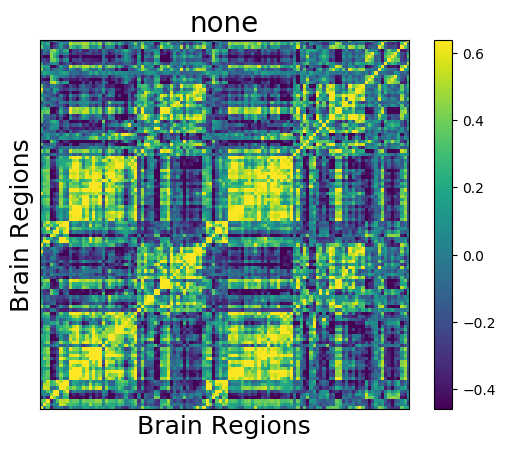

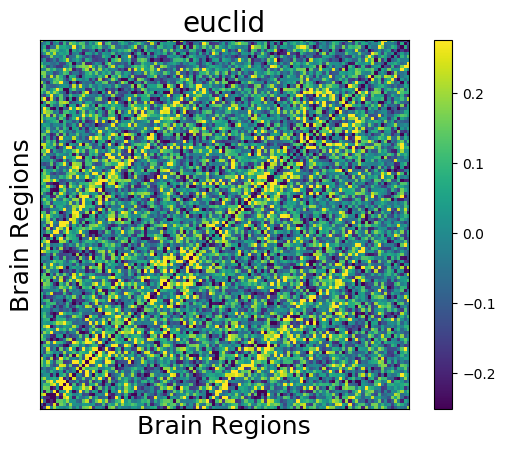

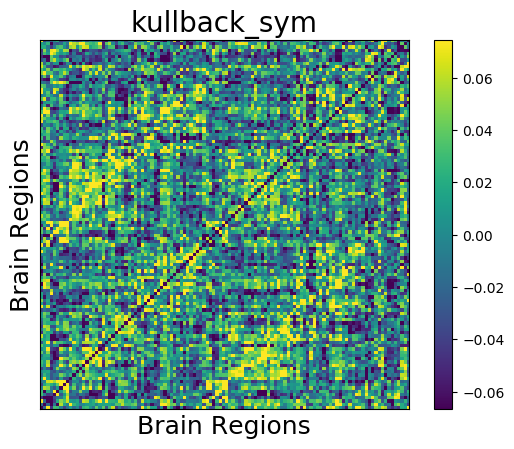

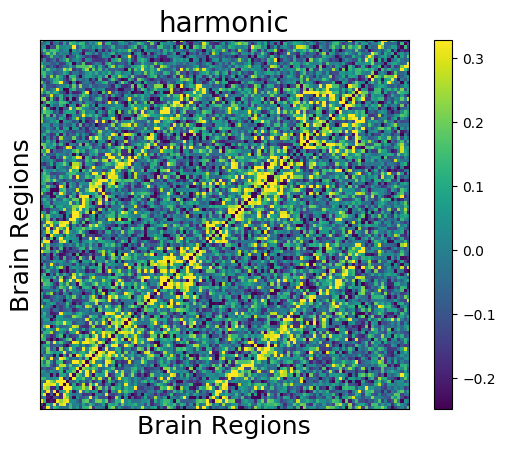

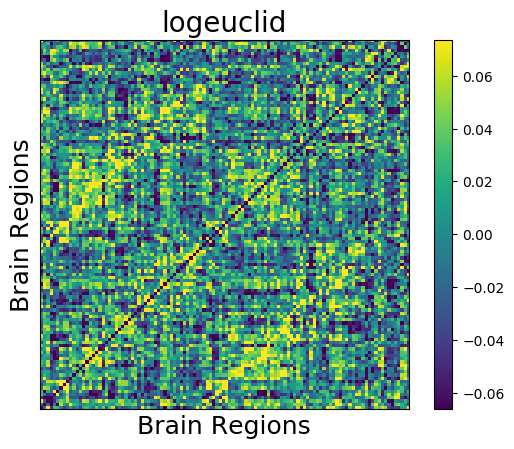

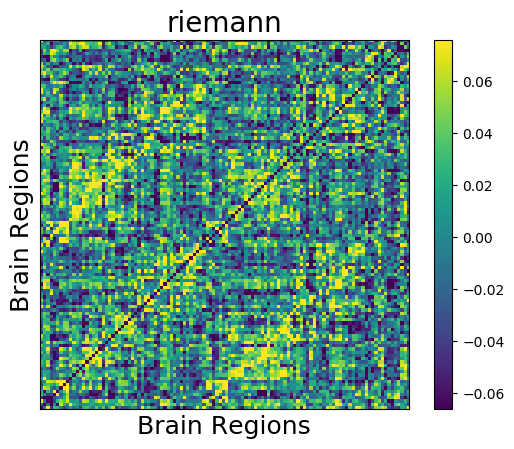

In [48]:
for ref in ['none', 'euclid', 'kullback_sym', 'harmonic', 'logeuclid', 'riemann']:
    all_FC, nSubj = get_schaefer(100, ref, twins=True)
    plt.style.use('default')
    sampleFC = all_FC[0]
    plt.imshow(sampleFC,origin='lower')
    plt.ylabel('Brain Regions')
    plt.xlabel('Brain Regions')
    plt.colorbar()
    plt.clim(np.percentile(sampleFC, 5), np.percentile(sampleFC, 95))
    plt.xticks([], [])
    plt.yticks([],[])
    plt.title(f'{ref}', fontdict = {'fontsize' : 20})
    plt.ylabel('Brain Regions',fontdict = {'fontsize' : 18})
    plt.xlabel('Brain Regions',fontdict = {'fontsize' : 18})
    plt.savefig(f'../results/projected_{ref}.eps', bbox_inches='tight')
    plt.show()
    

## Twins

### MZ Optimal PCA

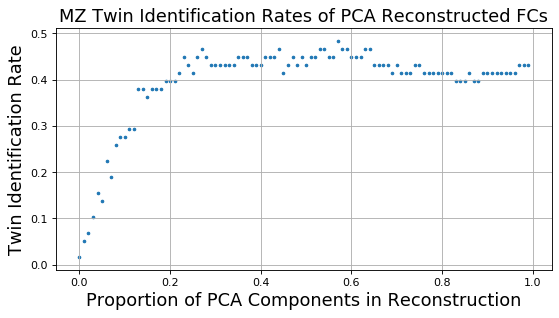

In [71]:
# PCA reconstruction of rest twin components
twin_pca = pd.read_csv('twins/twin_pca_optimal.csv', names=["PctComps", "Accuracy"])
plt.figure(figsize=(8, 4), dpi=80)
plt.scatter(twin_pca.PctComps, twin_pca.Accuracy, s=5)
plt.xlabel('Proportion of PCA Components in Reconstruction',fontdict = {'fontsize' : 16})
plt.ylabel('Twin Identification Rate' ,fontdict = {'fontsize' : 16})
plt.title('MZ Twin Identification Rates of PCA Reconstructed FCs' ,fontdict = {'fontsize' : 16})
plt.grid()
plt.savefig('twins/pca_optimal_recon.eps', bbox_inches='tight', transparent=True)
plt.show()

### DZ Optimal PCA

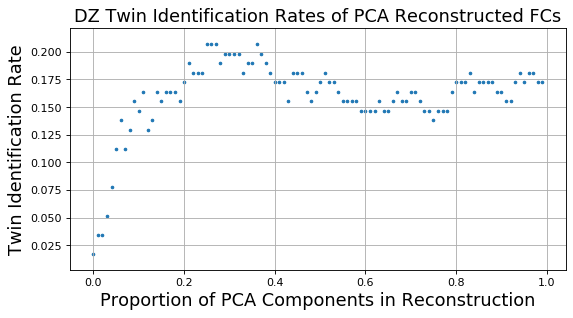

In [72]:
# PCA reconstruction of rest twin components
twin_pca = pd.read_csv('twins/DZ_twin_pca_optimal.csv', names=["PctComps", "Twin_Identification_Rate"])
plt.figure(figsize=(8, 4), dpi=80)
plt.scatter(twin_pca.PctComps, twin_pca.Twin_Identification_Rate, s=5)
plt.xlabel('Proportion of PCA Components in Reconstruction',fontdict = {'fontsize' : 16})
plt.ylabel('Twin Identification Rate' ,fontdict = {'fontsize' : 16})
plt.title('DZ Twin Identification Rates of PCA Reconstructed FCs' ,fontdict = {'fontsize' : 16})
plt.grid()
plt.savefig('twins/pca_optimal_recon_DZ.eps', bbox_inches='tight', transparent=True)

### MZ origmat

In [12]:
df = pd.read_csv('twins/MZ_twin_updated.csv', names=["First", "Twin Identification Rate"])
df['Parcellation'], df['Task'], df['Tangent Reference'] = df['First'].str.split(':', 2).str
df.drop(['First'], axis=1, inplace=True)
df.round(3)

/Users/michael/anaconda3/envs/fmri/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  


0.7636494252873564

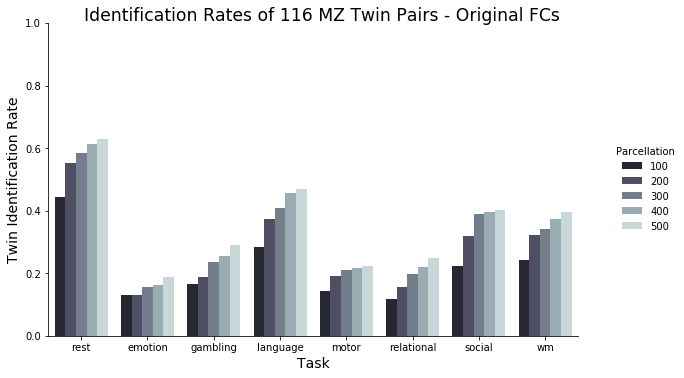

In [14]:
ref_plot = sns.catplot(x="Task", y="Twin Identification Rate", hue="Parcellation", data=df[df['Tangent Reference']=='original'],
                height=6, kind="bar", palette="bone").set(ylim=(0, 1))
ref_plot.fig.suptitle('Identification Rates of 116 MZ Twin Pairs - Original FCs', y=1.02, fontsize='xx-large')
ref_plot.fig.set_size_inches(10,5)
plt.savefig('twins/MZ_twin_pairs.eps', bbox_inches='tight', transparent=True)
plt.show()

/Users/michael/anaconda3/envs/fmri/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  This is separate from the ipykernel package so we can avoid doing imports until


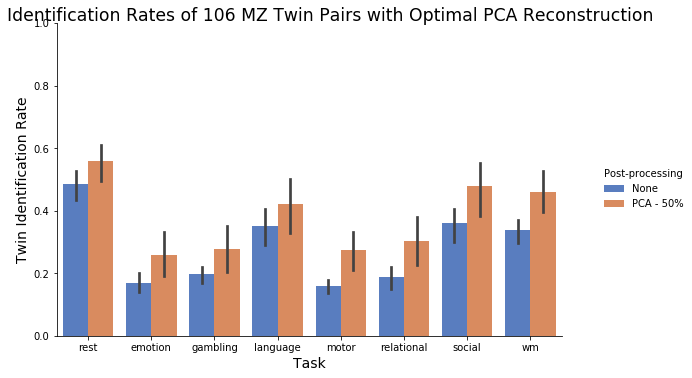

In [77]:
df['Post-processing'] = 'None'
df2 = pd.read_csv('twins/MZ_twin_parcellations_pca.csv', names=["First", "Twin Identification Rate"])
df2['Parcellation'], df2['Task'] = df2['First'].str.split(':', 1).str
df2.drop(['First'], axis=1, inplace=True)
df2.round(3)
df2 = df2[['Task', 'Parcellation', 'Twin Identification Rate']]
df2['Post-processing'] = 'PCA - 50%'
df3 = pd.concat([df, df2])
ref_plot = sns.catplot(x="Task", y="Twin Identification Rate", hue="Post-processing", data=df3,
                height=6, kind="bar", palette="muted").set(ylim=(0, 1))
ref_plot.fig.suptitle('Identification Rates of 106 MZ Twin Pairs with Optimal PCA Reconstruction', y=1.02, fontsize='xx-large')
ref_plot.fig.set_size_inches(10,5)
plt.savefig('twins/MZ_twin_pairs_pca_none.eps', bbox_inches='tight', transparent=True)
plt.show()

/Users/michael/anaconda3/envs/fmri/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  


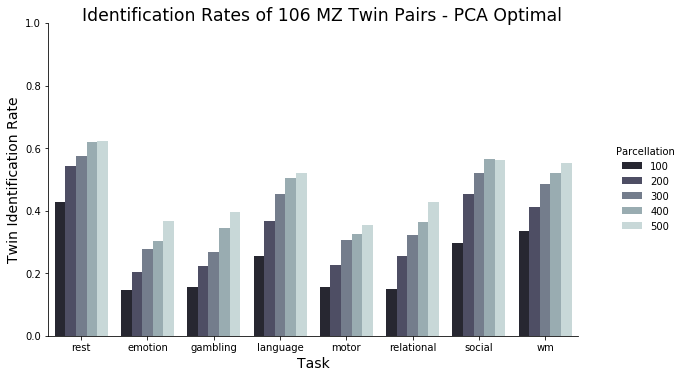

In [78]:
df2 = pd.read_csv('twins/MZ_twin_parcellations_pca.csv', names=["First", "Twin Identification Rate"])
df2['Parcellation'], df2['Task'] = df2['First'].str.split(':', 1).str
df2.drop(['First'], axis=1, inplace=True)
df2.round(3)
df2 = df2[['Task', 'Parcellation', 'Twin Identification Rate']]
df2['Post-processing'] = 'PCA - Optimal'
ref_plot = sns.catplot(x="Task", y="Twin Identification Rate", hue="Parcellation", data=df2,
                height=6, kind="bar", palette="bone").set(ylim=(0, 1))
ref_plot.fig.suptitle('Identification Rates of 106 MZ Twin Pairs - PCA Optimal', y=1.02, fontsize='xx-large')
ref_plot.fig.set_size_inches(10,5)
plt.savefig('twins/MZ_twin_pairs_pca.eps', bbox_inches='tight', transparent=True)
plt.show()

/Users/michael/anaconda3/envs/fmri/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  


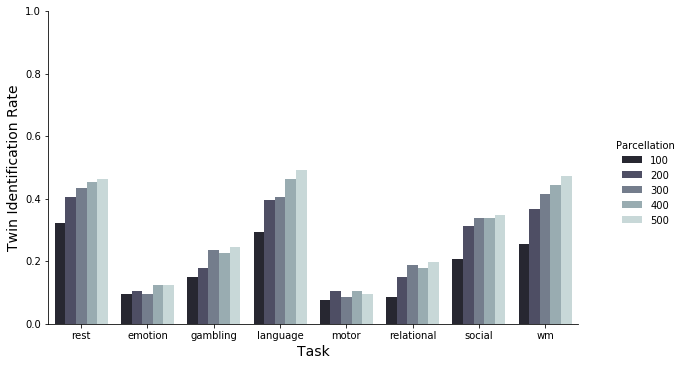

In [5]:
df2 = pd.read_csv('twins/MZ_twin_parcellations_single.csv', names=["First", "Twin Identification Rate"])
df2['Parcellation'], df2['Task'] = df2['First'].str.split(':', 1).str
df2.drop(['First'], axis=1, inplace=True)
df2.round(3)
df2 = df2[['Task', 'Parcellation', 'Twin Identification Rate']]
df2['Post-processing'] = 'PCA - Optimal'
ref_plot = sns.catplot(x="Task", y="Twin Identification Rate", hue="Parcellation", data=df2,
                height=6, kind="bar", palette="bone").set(ylim=(0, 1))
#ref_plot.fig.suptitle('Identification Rates of 106 MZ Twin Pairs  - PCA Optimal', y=1.02, fontsize='xx-large')
ref_plot.fig.set_size_inches(10,5)
plt.savefig('twins/MZ_twin_pairs_single.eps', bbox_inches='tight', transparent=True)
plt.show()

/Users/michael/anaconda3/envs/fmri/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  
/Users/michael/anaconda3/envs/fmri/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


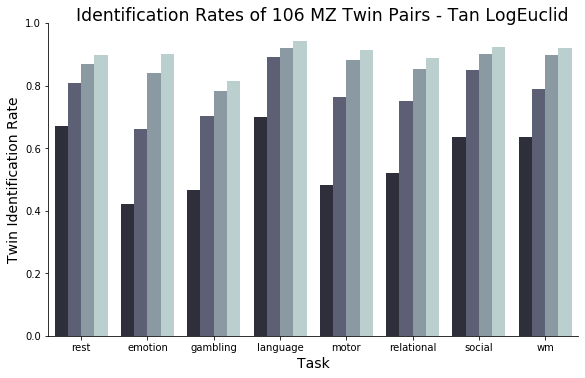

In [80]:
df = pd.read_csv('twins/MZ_twin_tangent.csv', names=["First", "Twin Identification Rate"])
df['Parcellation'], df['Task'], df['Reference'] = df['First'].str.split(':', 2).str
df.drop(['First'], axis=1, inplace=True)
df.round(3)
df = df[['Task', 'Parcellation', 'Reference', 'Twin Identification Rate']]
df_logeuclid = df[df['Reference']=='logeuclid']
df_logeuclid['Post-processing'] = 'Tangent - Logeuclid'
df_logeuclid = df_logeuclid.drop(['Reference'], axis=1)
ref_plot = sns.catplot(x="Task", y="Twin Identification Rate", hue="Parcellation", data=df_logeuclid,
                height=6, kind="bar", palette="bone").set(ylim=(0, 1))
ref_plot.fig.suptitle('Identification Rates of 106 MZ Twin Pairs - Tan LogEuclid', y=1.02, fontsize='xx-large')
ref_plot.fig.set_size_inches(10,5)
ref_plot._legend.remove()
plt.savefig('twins/MZ_twin_pairs_logeuclid.eps', bbox_inches='tight', transparent=True)
plt.show()

/Users/michael/anaconda3/envs/fmri/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  
/Users/michael/anaconda3/envs/fmri/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


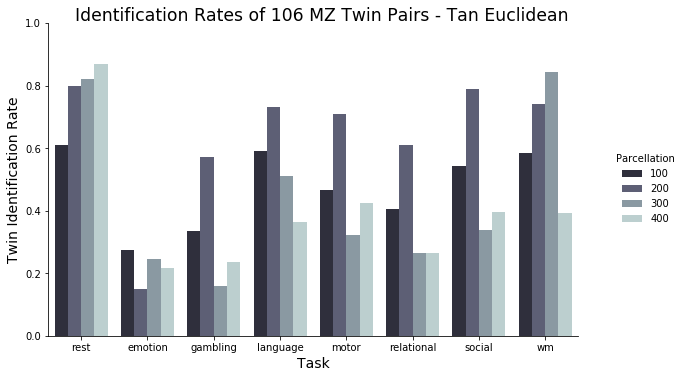

In [81]:
df = pd.read_csv('twins/MZ_twin_tangent.csv', names=["First", "Twin Identification Rate"])
df['Parcellation'], df['Task'], df['Reference'] = df['First'].str.split(':', 2).str
df.drop(['First'], axis=1, inplace=True)
df.round(3)
df = df[['Task', 'Parcellation', 'Reference', 'Twin Identification Rate']]
df_logeuclid = df[df['Reference']=='euclid']
df_logeuclid['Post-processing'] = 'Tangent - Euclidean'
df_logeuclid = df_logeuclid.drop(['Reference'], axis=1)
ref_plot = sns.catplot(x="Task", y="Twin Identification Rate", hue="Parcellation", data=df_logeuclid,
                height=6, kind="bar", palette="bone").set(ylim=(0, 1))
ref_plot.fig.suptitle('Identification Rates of 106 MZ Twin Pairs - Tan Euclidean', y=1.02, fontsize='xx-large')
ref_plot.fig.set_size_inches(10,5)
plt.savefig('twins/MZ_twin_pairs_euclid.eps', bbox_inches='tight', transparent=True)
plt.show()

### MZ Tangent

In [12]:
combined_csv = pd.concat([pd.read_csv(f) for f in ['twins/MZ_twin_tangent.csv','twins/MZ_twin_parcellations_new.csv' ] ])
combined_csv.to_csv( "combined_csv.csv", index=False, encoding='utf-8-sig')

/Users/michael/anaconda3/envs/fmri/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  


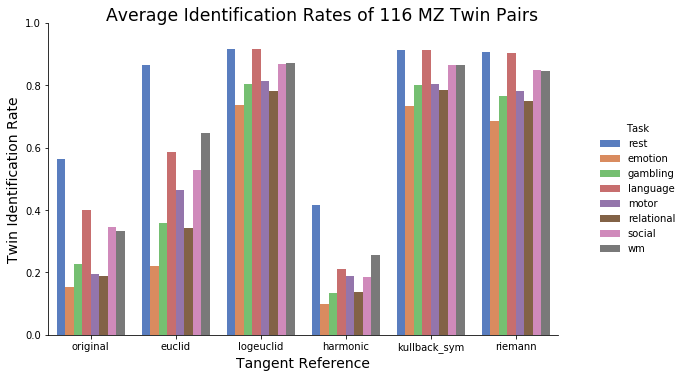

In [4]:
df = pd.read_csv('twins/MZ_twin_updated.csv', names=["First", "Twin Identification Rate"])
df['Parcellation'], df['Task'], df['Tangent Reference'] = df['First'].str.split(':', 2).str
df.drop(['First'], axis=1, inplace=True)
df.round(3)
df = df[['Task', 'Parcellation', 'Tangent Reference', 'Twin Identification Rate']]
ref_plot = sns.catplot(x="Tangent Reference", y="Twin Identification Rate", hue="Task", data=df,
                height=6, kind="bar", palette="muted", ci=None).set(ylim=(0, 1))
ref_plot.fig.suptitle('Average Identification Rates of 116 MZ Twin Pairs', y=1.02, fontsize='xx-large')
ref_plot.fig.set_size_inches(10,5)
plt.savefig('twins/MZ_twin_pairs_tangent_updated.eps', bbox_inches='tight', transparent=True)
plt.show()

/Users/michael/anaconda3/envs/fmri/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


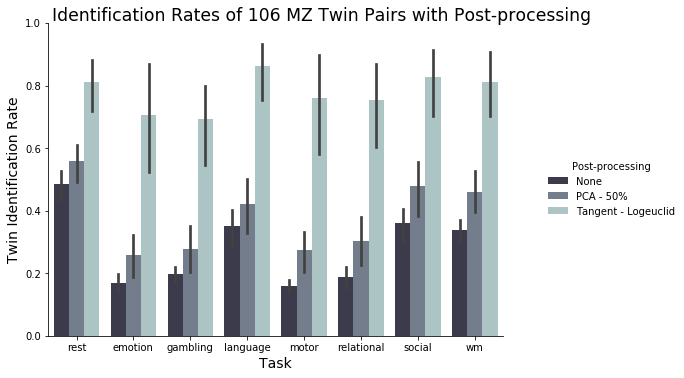

In [86]:
df_logeuclid = df[df['Tangent Reference']=='logeuclid']
df_logeuclid['Post-processing'] = 'Tangent - Logeuclid'
df_logeuclid = df_logeuclid.drop(['Tangent Reference'], axis=1)
df4 = pd.concat([df3, df_logeuclid])
ref_plot = sns.catplot(x="Task", y="Twin Identification Rate", hue="Post-processing", data=df4,
                height=6, kind="bar", palette="bone").set(ylim=(0, 1))
ref_plot.fig.suptitle('Identification Rates of 106 MZ Twin Pairs with Post-processing', y=1.02, fontsize='xx-large')
ref_plot.fig.set_size_inches(10,5)
plt.savefig('twins/MZ_twin_pairs_comparison.eps', bbox_inches='tight', transparent=True)
plt.show()

In [5]:
df100 = df4[df4['Parcellation'] == '100']
df200 = df4[df4['Parcellation'] == '200']
df300 = df4[df4['Parcellation'] == '300']
df400 = df4[df4['Parcellation'] == '400']
df500 = df4[df4['Parcellation'] == '500']
for parc in ['100', '200', '300', '400', '500']:
    ref_plot = sns.catplot(x="Task", y="Twin Identification Rate", hue="Post-processing", data=df4[df4['Parcellation'] == f'{parc}'],
                    height=6, kind="bar", palette="deep").set(ylim=(0, 1))
    ref_plot._legend.remove()
    ref_plot.fig.suptitle(f'Identification Rates of 106 MZ Twin Pairs: Schaefer{parc}', y=1.02, fontsize='xx-large', ha='center')
    ref_plot.fig.set_size_inches(10,5)
    plt.savefig(f'twins/MZ_twin_pairs_comparison_{parc}.eps', bbox_inches='tight', transparent=True)
    plt.show()

NameError: name 'df4' is not defined

### DZ origmat

In [88]:
df = pd.read_csv('twins/DZ_twin_parcellations.csv', names=["First", "Twin Identification Rate"])
df['Parcellation'], df['Task'] = df['First'].str.split(':', 1).str
df.drop(['First'], axis=1, inplace=True)
df.round(3)
df = df[['Task', 'Parcellation', 'Twin Identification Rate']]

/Users/michael/anaconda3/envs/fmri/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  


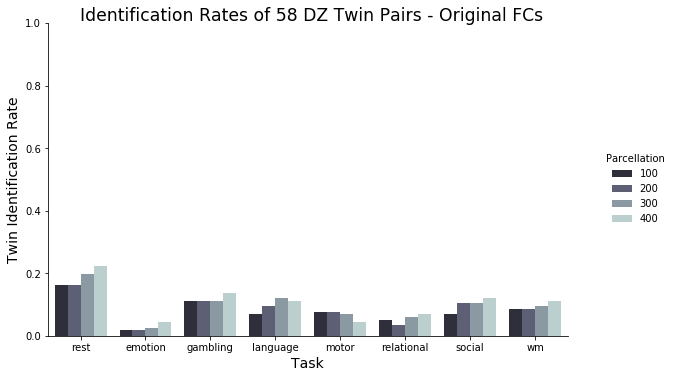

In [89]:
ref_plot = sns.catplot(x="Task", y="Twin Identification Rate", hue="Parcellation", data=df,
                height=6, kind="bar", palette="bone").set(ylim=(0, 1))
ref_plot.fig.suptitle('Identification Rates of 58 DZ Twin Pairs - Original FCs', y=1.02, fontsize='xx-large')
ref_plot.fig.set_size_inches(10,5)
plt.savefig('twins/DZ_twin_pairs.eps', bbox_inches='tight', transparent=True)
plt.show()

/Users/michael/anaconda3/envs/fmri/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  This is separate from the ipykernel package so we can avoid doing imports until


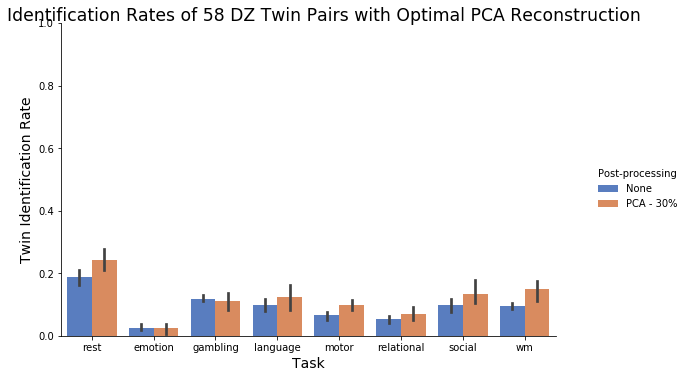

In [90]:
df['Post-processing'] = 'None'
df2 = pd.read_csv('twins/DZ_twin_parcellations_pca.csv', names=["First", "Twin Identification Rate"])
df2['Parcellation'], df2['Task'] = df2['First'].str.split(':', 1).str
df2.drop(['First'], axis=1, inplace=True)
df2.round(3)
df2 = df2[['Task', 'Parcellation', 'Twin Identification Rate']]
df2['Post-processing'] = 'PCA - 30%'
df3 = pd.concat([df, df2])
ref_plot = sns.catplot(x="Task", y="Twin Identification Rate", hue="Post-processing", data=df3,
                height=6, kind="bar", palette="muted").set(ylim=(0, 1))
ref_plot.fig.suptitle('Identification Rates of 58 DZ Twin Pairs with Optimal PCA Reconstruction', y=1.02, fontsize='xx-large')
ref_plot.fig.set_size_inches(10,5)
plt.savefig('twins/DZ_twin_pairs_pca_none.eps', bbox_inches='tight', transparent=True)
plt.show()

### DZ pca

/Users/michael/anaconda3/envs/fmri/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  


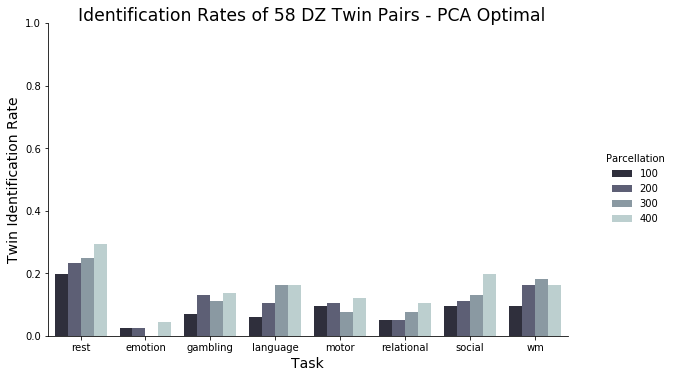

In [91]:
df2 = pd.read_csv('twins/DZ_twin_parcellations_pca.csv', names=["First", "Twin Identification Rate"])
df2['Parcellation'], df2['Task'] = df2['First'].str.split(':', 1).str
df2.drop(['First'], axis=1, inplace=True)
df2.round(3)
df2 = df2[['Task', 'Parcellation', 'Twin Identification Rate']]
df2['Post-processing'] = 'PCA - Optimal'
ref_plot = sns.catplot(x="Task", y="Twin Identification Rate", hue="Parcellation", data=df2,
                height=6, kind="bar", palette="bone").set(ylim=(0, 1))
ref_plot.fig.suptitle('Identification Rates of 58 DZ Twin Pairs - PCA Optimal', y=1.02, fontsize='xx-large')
ref_plot.fig.set_size_inches(10,5)
plt.savefig('twins/DZ_twin_pairs_pca.eps', bbox_inches='tight', transparent=True)
plt.show()

/Users/michael/anaconda3/envs/fmri/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  
/Users/michael/anaconda3/envs/fmri/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


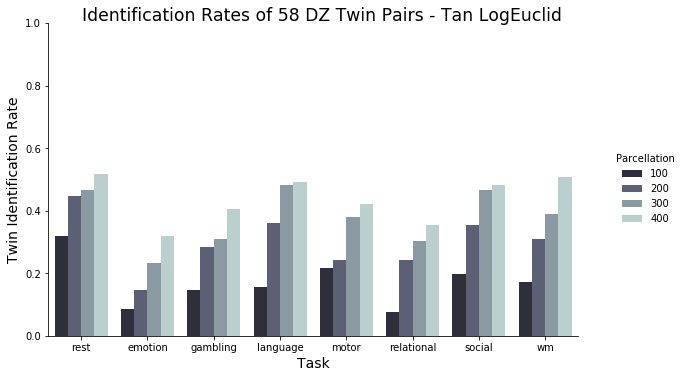

In [92]:
df = pd.read_csv('twins/DZ_twin_tangent.csv', names=["First", "Twin Identification Rate"])
df['Parcellation'], df['Task'], df['Reference'] = df['First'].str.split(':', 2).str
df.drop(['First'], axis=1, inplace=True)
df.round(3)
df = df[['Task', 'Parcellation', 'Reference', 'Twin Identification Rate']]
df_logeuclid = df[df['Reference']=='logeuclid']
df_logeuclid['Post-processing'] = 'Tangent - Logeuclid'
df_logeuclid = df_logeuclid.drop(['Reference'], axis=1)
ref_plot = sns.catplot(x="Task", y="Twin Identification Rate", hue="Parcellation", data=df_logeuclid,
                height=6, kind="bar", palette="bone").set(ylim=(0, 1))
ref_plot.fig.suptitle('Identification Rates of 58 DZ Twin Pairs - Tan LogEuclid', y=1.02, fontsize='xx-large')
ref_plot.fig.set_size_inches(10,5)
plt.savefig('twins/DZ_twin_pairs_logeuclid.eps', bbox_inches='tight', transparent=True)
plt.show()

/Users/michael/anaconda3/envs/fmri/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  
/Users/michael/anaconda3/envs/fmri/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


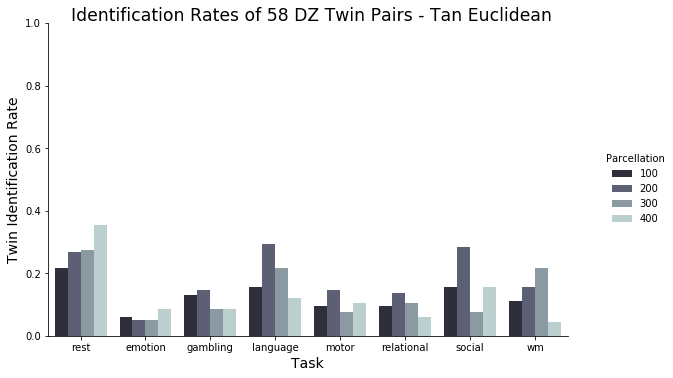

In [93]:
df = pd.read_csv('twins/DZ_twin_tangent.csv', names=["First", "Twin Identification Rate"])
df['Parcellation'], df['Task'], df['Reference'] = df['First'].str.split(':', 2).str
df.drop(['First'], axis=1, inplace=True)
df.round(3)
df = df[['Task', 'Parcellation', 'Reference', 'Twin Identification Rate']]
df_logeuclid = df[df['Reference']=='euclid']
df_logeuclid['Post-processing'] = 'Tangent - Euclidean'
df_logeuclid = df_logeuclid.drop(['Reference'], axis=1)
ref_plot = sns.catplot(x="Task", y="Twin Identification Rate", hue="Parcellation", data=df_logeuclid,
                height=6, kind="bar", palette="bone").set(ylim=(0, 1))
ref_plot.fig.suptitle('Identification Rates of 58 DZ Twin Pairs - Tan Euclidean', y=1.02, fontsize='xx-large')
ref_plot.fig.set_size_inches(10,5)
plt.savefig('twins/DZ_twin_pairs_euclid.eps', bbox_inches='tight', transparent=True)
plt.show()

### DZ Tangent

/Users/michael/anaconda3/envs/fmri/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  


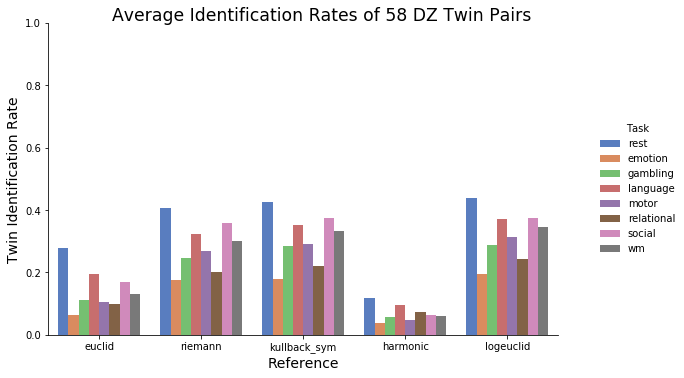

In [96]:
df = pd.read_csv('twins/DZ_twin_tangent.csv', names=["First", "Twin Identification Rate"])
df['Parcellation'], df['Task'], df['Reference'] = df['First'].str.split(':', 2).str
df.drop(['First'], axis=1, inplace=True)
df.round(3)
df = df[['Task', 'Parcellation', 'Reference', 'Twin Identification Rate']]
ref_plot = sns.catplot(x="Reference", y="Twin Identification Rate", hue="Task", data=df,
                height=6, kind="bar", palette="muted", ci=None).set(ylim=(0, 1))
ref_plot.fig.suptitle('Average Identification Rates of 58 DZ Twin Pairs', y=1.02, fontsize='xx-large')
ref_plot.fig.set_size_inches(10,5)
plt.savefig('twins/DZ_twin_pairs_tangent.eps', bbox_inches='tight', transparent=True)
plt.show()

/Users/michael/anaconda3/envs/fmri/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


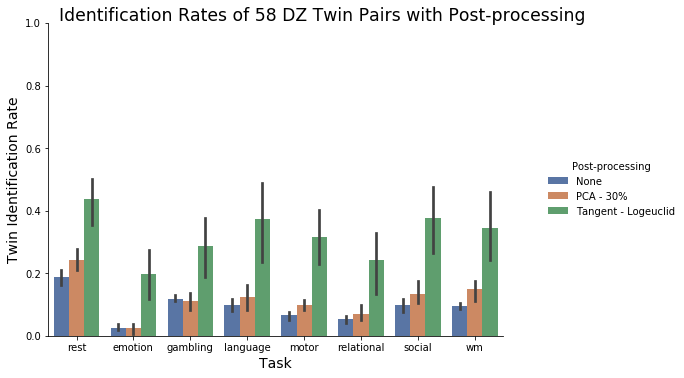

In [97]:
df_logeuclid = df[df['Reference']=='logeuclid']
df_logeuclid['Post-processing'] = 'Tangent - Logeuclid'
df_logeuclid = df_logeuclid.drop(['Reference'], axis=1)
df4 = pd.concat([df3, df_logeuclid])
ref_plot = sns.catplot(x="Task", y="Twin Identification Rate", hue="Post-processing", data=df4,
                height=6, kind="bar", palette="deep").set(ylim=(0, 1))
ref_plot.fig.suptitle('Identification Rates of 58 DZ Twin Pairs with Post-processing', y=1.02, fontsize='xx-large')
ref_plot.fig.set_size_inches(10,5)
plt.savefig('twins/DZ_twin_pairs_comparison.eps', bbox_inches='tight', transparent=True)
plt.show()

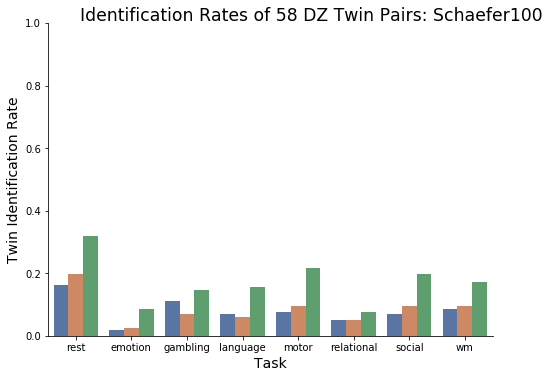

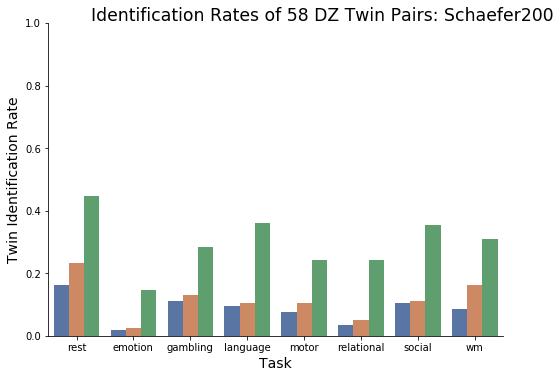

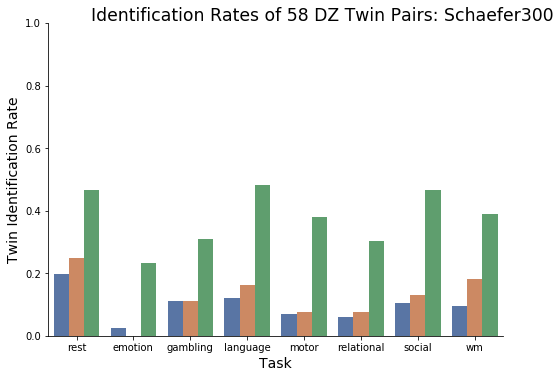

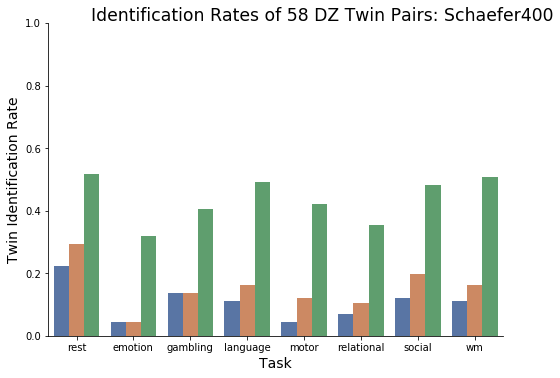

In [100]:
df100 = df4[df4['Parcellation'] == '100']
df200 = df4[df4['Parcellation'] == '200']
df300 = df4[df4['Parcellation'] == '300']
df400 = df4[df4['Parcellation'] == '400']
for parc in ['100', '200', '300', '400']:
    ref_plot = sns.catplot(x="Task", y="Twin Identification Rate", hue="Post-processing", data=df4[df4['Parcellation'] == f'{parc}'],
                    height=6, kind="bar", palette="deep").set(ylim=(0, 1))
    ref_plot._legend.remove()
    ref_plot.fig.suptitle(f'Identification Rates of 58 DZ Twin Pairs: Schaefer{parc}', y=1.02, fontsize='xx-large', ha='center')
    ref_plot.fig.set_size_inches(10,5)
    plt.savefig(f'twins/DZ_twin_pairs_comparison_{parc}.eps', bbox_inches='tight', transparent=True)
    plt.show()

## Test/Retest Subject Identification

In [120]:
df = pd.read_csv('twins/MZ_testretest_orig.csv', names=["First", "Identification Rate"])
df['Parcellation'], df['Task'] = df['First'].str.split(':', 1).str
df.drop(['First'], axis=1, inplace=True)
df.round(3)
df = df[['Task', 'Parcellation', 'Identification Rate']]
np.mean(df['Identification Rate'][df['Task'] == 'rest'])

/Users/michael/anaconda3/envs/fmri/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  


0.4740566037735849

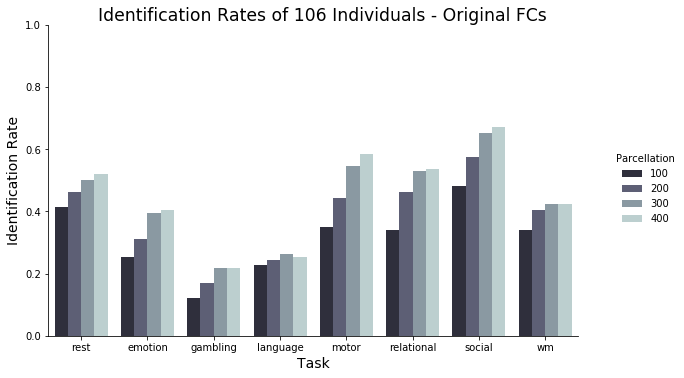

In [121]:
ref_plot = sns.catplot(x="Task", y="Identification Rate", hue="Parcellation", data=df,
                height=6, kind="bar", palette="bone").set(ylim=(0, 1))
ref_plot.fig.suptitle('Identification Rates of 106 Individuals - Original FCs', y=1.02, fontsize='xx-large')
ref_plot.fig.set_size_inches(10,5)
plt.savefig('twins/test_retest.eps', bbox_inches='tight', transparent=True)
plt.show()

/Users/michael/anaconda3/envs/fmri/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  This is separate from the ipykernel package so we can avoid doing imports until


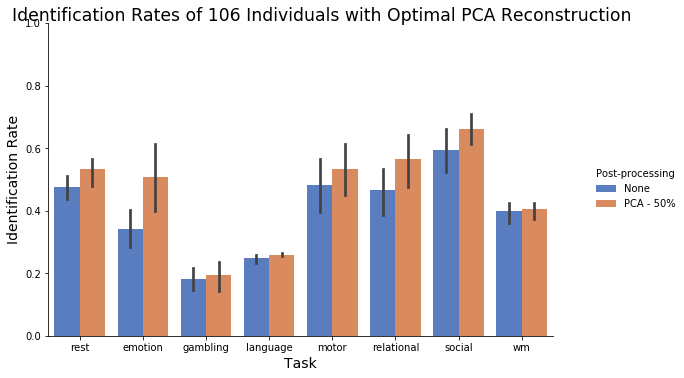

In [122]:
df['Post-processing'] = 'None'
df2 = pd.read_csv('twins/MZ_testretest_pca.csv', names=["First", "Identification Rate"])
df2['Parcellation'], df2['Task'] = df2['First'].str.split(':', 1).str
df2.drop(['First'], axis=1, inplace=True)
df2.round(3)
df2 = df2[['Task', 'Parcellation', 'Identification Rate']]
df2['Post-processing'] = 'PCA - 50%'
df3 = pd.concat([df, df2])
ref_plot = sns.catplot(x="Task", y="Identification Rate", hue="Post-processing", data=df3,
                height=6, kind="bar", palette="muted").set(ylim=(0, 1))
ref_plot.fig.suptitle('Identification Rates of 106 Individuals with Optimal PCA Reconstruction', y=1.02, fontsize='xx-large')
ref_plot.fig.set_size_inches(10,5)
plt.savefig('twins/test_retest_pca.eps', bbox_inches='tight', transparent=True)
plt.show()

/Users/michael/anaconda3/envs/fmri/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  


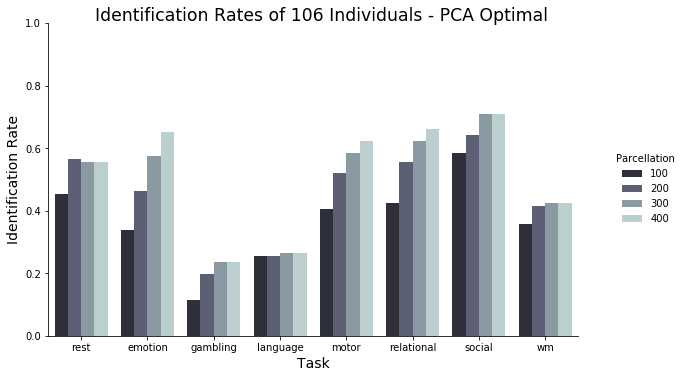

In [123]:
df2 = pd.read_csv('twins/MZ_testretest_pca.csv', names=["First", "Identification Rate"])
df2['Parcellation'], df2['Task'] = df2['First'].str.split(':', 1).str
df2.drop(['First'], axis=1, inplace=True)
df2.round(3)
df2 = df2[['Task', 'Parcellation', 'Identification Rate']]
df2['Post-processing'] = 'PCA - Optimal'
ref_plot = sns.catplot(x="Task", y="Identification Rate", hue="Parcellation", data=df2,
                height=6, kind="bar", palette="bone").set(ylim=(0, 1))
ref_plot.fig.suptitle('Identification Rates of 106 Individuals - PCA Optimal', y=1.02, fontsize='xx-large')
ref_plot.fig.set_size_inches(10,5)
plt.savefig('twins/test_retest_pca.eps', bbox_inches='tight', transparent=True)
plt.show()

/Users/michael/anaconda3/envs/fmri/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  


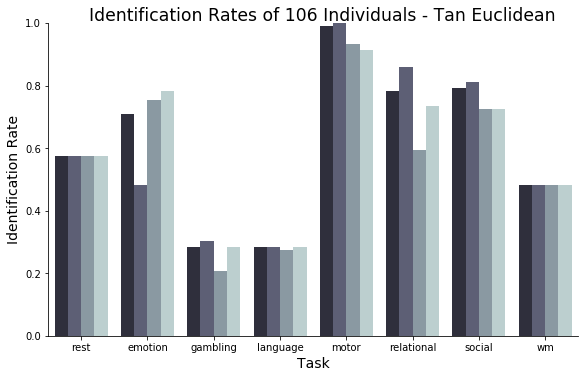

In [124]:
df = pd.read_csv('twins/MZ_testretest_euclid.csv', names=["First", "Identification Rate"])
df['Parcellation'], df['Task'] = df['First'].str.split(':', 2).str
df.drop(['First'], axis=1, inplace=True)
df.round(3)
df = df[['Task', 'Parcellation', 'Identification Rate']]
ref_plot = sns.catplot(x="Task", y="Identification Rate", hue="Parcellation", data=df,
                height=6, kind="bar", palette="bone").set(ylim=(0, 1))
ref_plot.fig.suptitle('Identification Rates of 106 Individuals - Tan Euclidean', y=1.02, fontsize='xx-large')
ref_plot.fig.set_size_inches(10,5)
ref_plot._legend.remove()
plt.savefig('twins/test_retest_euclid.eps', bbox_inches='tight', transparent=True)
plt.show()

/Users/michael/anaconda3/envs/fmri/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  


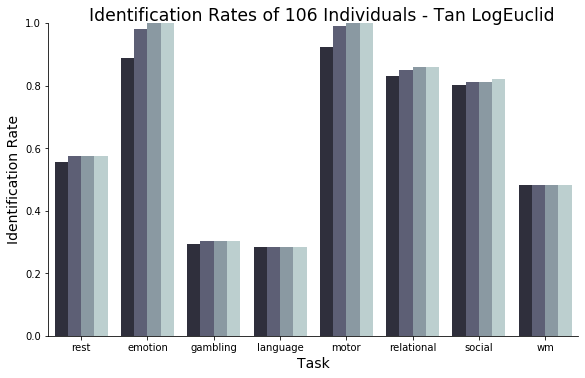

In [125]:
df = pd.read_csv('twins/MZ_testretest_logeuclid.csv', names=["First", "Identification Rate"])
df['Parcellation'], df['Task'] = df['First'].str.split(':', 2).str
df.drop(['First'], axis=1, inplace=True)
df.round(3)
df = df[['Task', 'Parcellation', 'Identification Rate']]
ref_plot = sns.catplot(x="Task", y="Identification Rate", hue="Parcellation", data=df,
                height=6, kind="bar", palette="bone").set(ylim=(0, 1))
ref_plot.fig.suptitle('Identification Rates of 106 Individuals - Tan LogEuclid', y=1.02, fontsize='xx-large')
ref_plot.fig.set_size_inches(10,5)
ref_plot._legend.remove()
plt.savefig('twins/test_retest_logeuclid.eps', bbox_inches='tight', transparent=True)
plt.show()

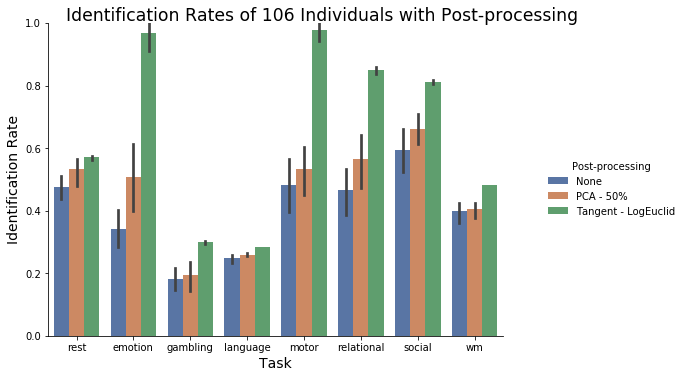

In [126]:
df['Post-processing'] = 'Tangent - LogEuclid'
df4 = pd.concat([df3, df])
ref_plot = sns.catplot(x="Task", y="Identification Rate", hue="Post-processing", data=df4,
                height=6, kind="bar", palette="deep").set(ylim=(0, 1))
ref_plot.fig.suptitle('Identification Rates of 106 Individuals with Post-processing', y=1.02, fontsize='xx-large')
ref_plot.fig.set_size_inches(10,5)
plt.savefig('twins/test_retest_comparison.eps', bbox_inches='tight', transparent=True)
plt.show()

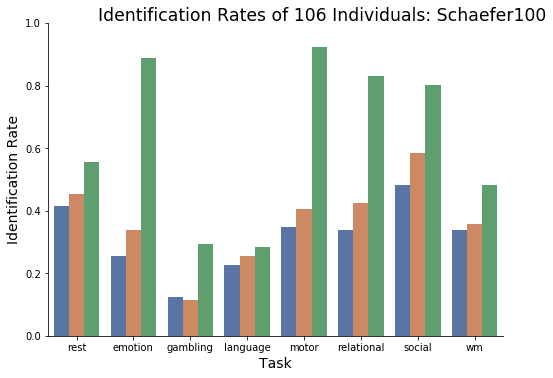

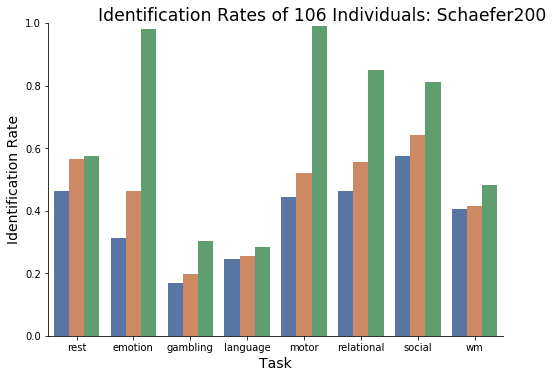

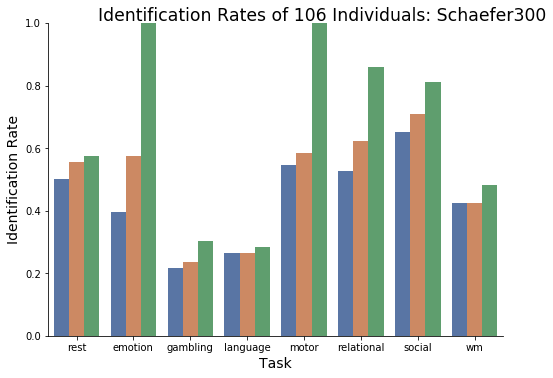

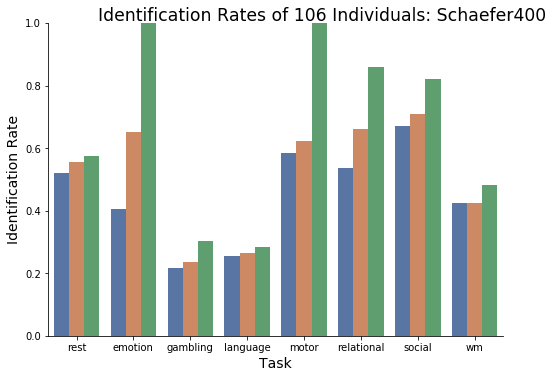

In [127]:
df100 = df4[df4['Parcellation'] == '100']
df200 = df4[df4['Parcellation'] == '200']
df300 = df4[df4['Parcellation'] == '300']
df400 = df4[df4['Parcellation'] == '400']
for parc in ['100', '200', '300', '400']:
    ref_plot = sns.catplot(x="Task", y="Identification Rate", hue="Post-processing", data=df4[df4['Parcellation'] == f'{parc}'],
                    height=6, kind="bar", palette="deep").set(ylim=(0, 1))
    ref_plot._legend.remove()
    ref_plot.fig.suptitle(f'Identification Rates of 106 Individuals: Schaefer{parc}', y=1.02, fontsize='xx-large', ha='center')
    ref_plot.fig.set_size_inches(10,5)
    plt.savefig(f'twins/test_retest_comparison_{parc}.eps', bbox_inches='tight', transparent=True)
    plt.show()